In [136]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

In [137]:
import pandas as pd
import numpy as np
from bayesian.train_bn import structure_learning, parameter_learning, parameter_learning_mix
from preprocess.discretization import get_nodes_type, discretization, inverse_discretization, code_categories
from bayesian.save_bn import save_structure, save_params, read_structure, read_params
from external.libpgm.hybayesiannetwork import HyBayesianNetwork
from visualization.visualization import draw_BN
from bayesian.calculate_accuracy import calculate_acc
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from copy import copy
from external.libpgm.sampleaggregator import SampleAggregator
import operator
from sklearn.metrics import accuracy_score, mean_squared_error
from scipy import stats
from scipy.stats import multivariate_normal
from sklearn.mixture import GaussianMixture
import math
from pomegranate import DiscreteDistribution
import random
from sklearn.model_selection import train_test_split

In [138]:
df_result_accuracy = pd.DataFrame(columns = ['Parameter', 'Strategy', 'Alg', 'accuracy'])
df_result_rmse = pd.DataFrame(columns = ['Parameter', 'Strategy', 'Alg', 'rmse'])

In [139]:
geo = geo = pd.read_csv('../datasets/hackathon_processed.csv')
columns = ['Tectonic regime', 'Period', 'Lithology', 'Structural setting', 'Hydrocarbon type', 'Gross','Netpay','Porosity','Permeability', 'Depth']
geo = geo[columns]
geo.dropna(inplace=True)
geo.reset_index(inplace=True, drop=True)

In [140]:
geo_train, geo_test = train_test_split(geo, test_size=0.1)
geo_train.reset_index(inplace=True, drop=True)
geo_test.reset_index(inplace=True, drop=True)

In [141]:
geo_types = get_nodes_type(geo)
geo_types

{'Tectonic regime': 'disc',
 'Period': 'disc',
 'Lithology': 'disc',
 'Structural setting': 'disc',
 'Hydrocarbon type': 'disc',
 'Gross': 'cont',
 'Netpay': 'cont',
 'Porosity': 'cont',
 'Permeability': 'cont',
 'Depth': 'cont'}

In [142]:
colums_for_code = []
columns_for_disc = []
for c in columns:
    if geo_types[c] == 'disc':
        colums_for_code.append(c)
    else:
        columns_for_disc.append(c)

In [143]:
geo_coded, label_coder = code_categories(geo_train, 'label', colums_for_code)
geo_discrete, coder = discretization(geo_coded, 'equal_frequency', columns_for_disc)
geo_only_discrete, discrete_coder = discretization(geo_train, 'equal_frequency', columns_for_disc)

# Hill Climbing

# Дискретная структра + смешанные параметры

In [144]:
bn_geo = structure_learning(geo_discrete, 'HC', 'MI', geo_types)

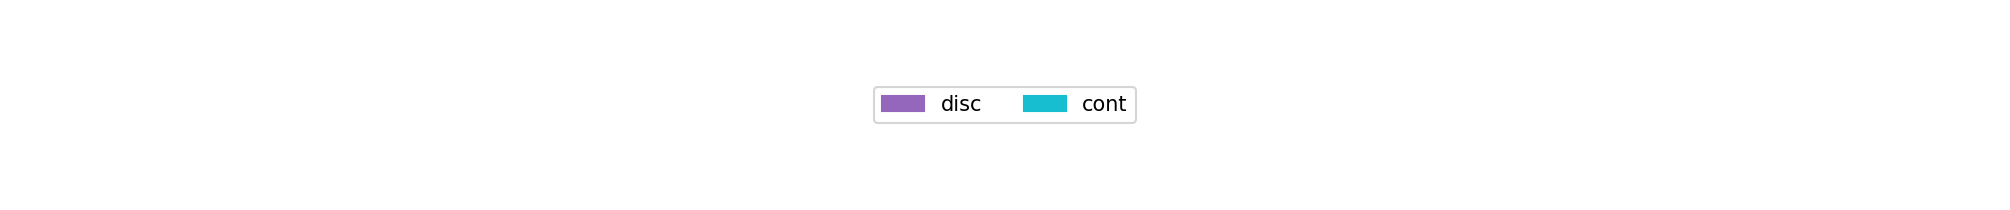

In [145]:
draw_BN(bn_geo, geo_types, 'geo_net')

In [146]:
params = parameter_learning(geo_train, geo_types, bn_geo)

In [147]:
save_structure(bn_geo, 'geo_net')
skel = read_structure('geo_net')
save_params(params, 'geo_net_param')
params = read_params('geo_net_param')
geo_bn = HyBayesianNetwork(skel, params)

In [148]:
acc, rmse, real_data, pred_data = calculate_acc(geo_bn, geo_test, columns)

6
12
15
16
20
20
21
22
22
22
27
40


In [149]:
acc

{'Tectonic regime': 0.53,
 'Period': 0.22,
 'Lithology': 0.53,
 'Structural setting': 0.2,
 'Hydrocarbon type': 0.67}

In [150]:
rmse

{'Gross': 456.86,
 'Netpay': 64.39,
 'Porosity': 5.63,
 'Permeability': 917.9,
 'Depth': 1055.13}

In [151]:
for key in acc.keys():
    df_result_accuracy = df_result_accuracy.append({'Parameter': key, 'Strategy': 'HC', 'Alg':'D+M','accuracy':acc[key]}, ignore_index=True)
for key in rmse.keys():
    df_result_rmse = df_result_rmse.append({'Parameter': key, 'Strategy': 'HC', 'Alg':'D+M','rmse':rmse[key]}, ignore_index=True)

In [152]:
sample_d_m_hc = pd.DataFrame(geo_bn.randomsample(700))
sample_d_m_hc_gross = sample_d_m_hc.loc[sample_d_m_hc['Gross'] > 0]
sample_d_m_hc_netpay = sample_d_m_hc.loc[sample_d_m_hc['Netpay'] > 0]
sample_d_m_hc_porosity = sample_d_m_hc.loc[sample_d_m_hc['Porosity'] > 0]
sample_d_m_hc_permeability = sample_d_m_hc.loc[sample_d_m_hc['Permeability'] > 0]
sample_d_m_hc_depth = sample_d_m_hc.loc[sample_d_m_hc['Depth'] > 0]

# Смешанная структура + смешанные параметры

In [153]:
bn_geo = structure_learning(geo_coded, 'HC', 'MI', geo_types)

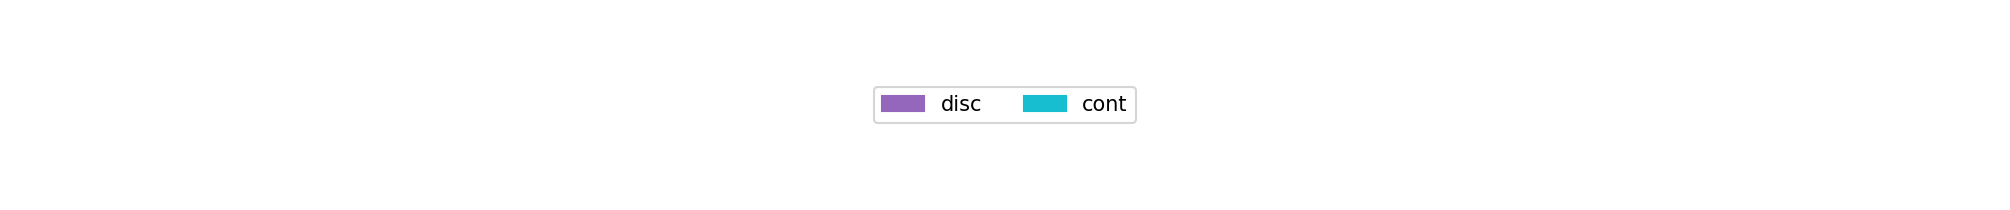

In [154]:
draw_BN(bn_geo, geo_types, 'geo_net')

In [155]:
params = parameter_learning(geo_train, geo_types, bn_geo)

In [156]:
save_structure(bn_geo, 'geo_net')
skel = read_structure('geo_net')
save_params(params, 'geo_net_param')
params = read_params('geo_net_param')
geo_bn = HyBayesianNetwork(skel, params)

In [157]:
acc, rmse, real, pred = calculate_acc(geo_bn, geo_test, columns)

6
6
6
6
6
9
9
9
9
9
12
12
12
12
12
17
17
17
17
17
20
20
20
20
20
21
21
21
21
21
22
22
22
22
22
22
35
35
35
35
35
42
42
42
42
42


In [158]:
acc

{'Tectonic regime': 0.53,
 'Period': 0.22,
 'Lithology': 0.51,
 'Structural setting': 0.2,
 'Hydrocarbon type': 0.67}

In [159]:
rmse

{'Gross': 342.26,
 'Netpay': 53.69,
 'Porosity': 3.93,
 'Permeability': 887.36,
 'Depth': 920.58}

In [160]:
for key in acc.keys():
    df_result_accuracy = df_result_accuracy.append({'Parameter': key, 'Strategy': 'HC', 'Alg':'M+M','accuracy':acc[key]}, ignore_index=True)
for key in rmse.keys():
    df_result_rmse = df_result_rmse.append({'Parameter': key, 'Strategy': 'HC', 'Alg':'M+M','rmse':rmse[key]}, ignore_index=True)

In [161]:
sample_m_m_hc = pd.DataFrame(geo_bn.randomsample(700))
sample_m_m_hc_gross = sample_m_m_hc.loc[sample_m_m_hc['Gross'] > 0]
sample_m_m_hc_netpay = sample_m_m_hc.loc[sample_m_m_hc['Netpay'] > 0]
sample_m_m_hc_porosity = sample_m_m_hc.loc[sample_m_m_hc['Porosity'] > 0]
sample_m_m_hc_permeability = sample_m_m_hc.loc[sample_m_m_hc['Permeability'] > 0]
sample_m_m_hc_depth = sample_m_m_hc.loc[sample_m_m_hc['Depth'] > 0]

# Дискретная стурктура + дискретные параметры

In [162]:
geo_new_types = {'Tectonic regime': 'disc',
 'Period': 'disc',
 'Lithology': 'disc',
 'Structural setting': 'disc',
 'Hydrocarbon type': 'disc',
 'Gross': 'disc',
 'Netpay': 'disc',
 'Porosity': 'disc',
 'Permeability': 'disc',
 'Depth': 'disc'}

In [163]:
bn_geo = structure_learning(geo_discrete, 'HC', 'MI', geo_new_types)

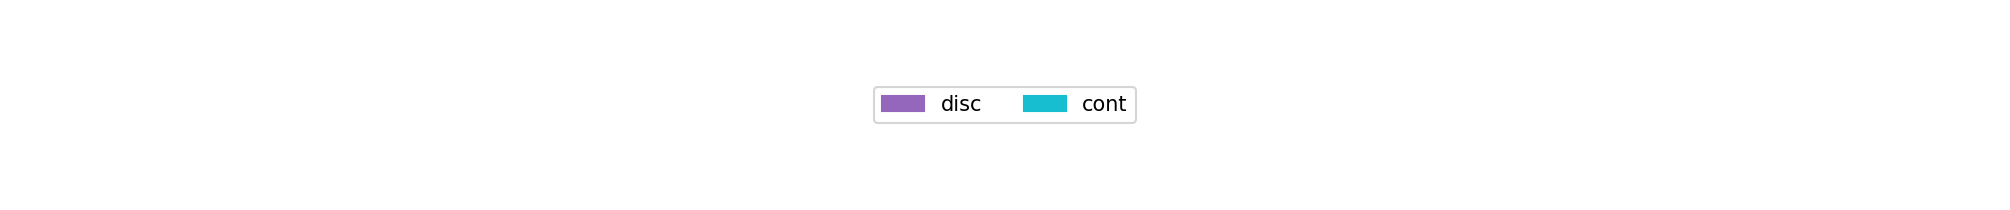

In [164]:
draw_BN(bn_geo, geo_types, 'geo_net')

In [165]:
params = parameter_learning(geo_only_discrete, geo_new_types, bn_geo)

In [166]:
save_structure(bn_geo, 'geo_net')
skel = read_structure('geo_net')
save_params(params, 'geo_net_param')
params = read_params('geo_net_param')
geo_bn = HyBayesianNetwork(skel, params)

In [167]:
test_discrete = copy(geo_test)

In [168]:
test_discrete[columns_for_disc] = discrete_coder.transform(geo_test[columns_for_disc].values) 

In [169]:
for c in columns_for_disc:
    test_discrete[c] = test_discrete[c].apply(lambda x: int(x))
test_discrete

,Tectonic regime,Period,Lithology,Structural setting,Hydrocarbon type,Gross,Netpay,Porosity,Permeability,Depth
0,EXTENSION,CRETACEOUS,SANDSTONE,INTRACRATONIC,OIL,0,0,4,4,0
1,COMPRESSION,CRETACEOUS,SANDSTONE,FORELAND,OIL,0,0,3,3,0
2,INVERSION,CRETACEOUS,SANDSTONE,INVERSION,OIL,2,0,3,3,0
3,COMPRESSION,CARBONIFEROUS,LIMESTONE,INTRACRATONIC,OIL,0,0,2,1,1
4,COMPRESSION,CARBONIFEROUS,DOLOMITIC LIMESTONE,INTRACRATONIC,OIL,1,0,0,0,1
5,COMPRESSION,CARBONIFEROUS,LIMESTONE,SUB-SALT,OIL,2,2,0,1,2
6,EXTENSION,ORDOVICIAN,DOLOMITE,RIFT,OIL,3,2,0,1,2
7,COMPRESSION,DEVONIAN,LIMESTONE,FORELAND,OIL,3,2,0,2,0
8,COMPRESSION,TRIASSIC,CONGLOMERATE,THRUST,OIL,3,1,2,3,2
9,EXTENSION,CARBONIFEROUS,DOLOMITE,INTRACRATONIC,OIL,0,0,2,1,3


In [170]:
acc, rmse, real, pred = calculate_acc(geo_bn, test_discrete, columns)

22
22
22
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the f

In [171]:
acc

{'Tectonic regime': 0.53,
 'Period': 0.22,
 'Lithology': 0.51,
 'Structural setting': 0.2,
 'Hydrocarbon type': 0.67,
 'Gross': 0.0,
 'Netpay': 0.0,
 'Porosity': 0.0,
 'Permeability': 0.0,
 'Depth': 0.0}

In [172]:
for key in colums_for_code:
    df_result_accuracy = df_result_accuracy.append({'Parameter': key, 'Strategy': 'HC', 'Alg':'D+D','accuracy':acc[key]}, ignore_index=True)

In [173]:
invers_real = inverse_discretization(pd.DataFrame(np.transpose(real[5:10]), columns=['Gross', 'Netpay', 'Porosity', 'Permeability', 'Depth']), ['Gross', 'Netpay', 'Porosity', 'Permeability', 'Depth'], discrete_coder)

In [174]:
invers_pred = inverse_discretization(pd.DataFrame(np.transpose(pred[5:10]), columns=['Gross', 'Netpay', 'Porosity', 'Permeability', 'Depth']), ['Gross', 'Netpay', 'Porosity', 'Permeability', 'Depth'], discrete_coder)

In [175]:
m = mean_squared_error(invers_real['Gross'], invers_pred['Gross'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'Gross', 'Strategy': 'HC', 'Alg':'D+D','rmse':m}, ignore_index=True)

In [176]:
m = mean_squared_error(invers_real['Netpay'], invers_pred['Netpay'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'Netpay', 'Strategy': 'HC', 'Alg':'D+D','rmse':m}, ignore_index=True)

In [177]:
m = mean_squared_error(invers_real['Porosity'], invers_pred['Porosity'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'Porosity', 'Strategy': 'HC', 'Alg':'D+D','rmse':m}, ignore_index=True)

In [178]:
m = mean_squared_error(invers_real['Permeability'], invers_pred['Permeability'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'Permeability', 'Strategy': 'HC', 'Alg':'D+D','rmse':m}, ignore_index=True)

In [179]:
m = mean_squared_error(invers_real['Depth'], invers_pred['Depth'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'Depth', 'Strategy': 'HC', 'Alg':'D+D','rmse':m}, ignore_index=True)

In [180]:
sample_d_d_hc = pd.DataFrame(geo_bn.randomsample(500))
sample_d_d_hc = inverse_discretization(sample_d_d_hc, columns_for_disc, discrete_coder)

# Смешанная структура + дискретные параметры

In [181]:
bn_geo = structure_learning(geo_coded, 'HC', 'MI', geo_new_types)

ed in double_scalars
  delta1 = -1* nrow * (mi_old - mi_new)
c:\Users\anaxa\Documents\Projects\Mixed-Learning-of-Bayesian-Networks\bayesian\redef_HC.py:258: RuntimeWarning: overflow encountered in double_scalars
  delta2 = nrow * (mi_old - mi_new)
c:\Users\anaxa\Documents\Projects\Mixed-Learning-of-Bayesian-Networks\bayesian\redef_HC.py:178: RuntimeWarning: overflow encountered in double_scalars
  delta_score = nrow * (mi_old - mi_new)
c:\Users\anaxa\Documents\Projects\Mixed-Learning-of-Bayesian-Networks\bayesian\redef_HC.py:178: RuntimeWarning: overflow encountered in double_scalars
  delta_score = nrow * (mi_old - mi_new)
c:\Users\anaxa\Documents\Projects\Mixed-Learning-of-Bayesian-Networks\bayesian\redef_HC.py:178: RuntimeWarning: overflow encountered in double_scalars
  delta_score = nrow * (mi_old - mi_new)
c:\Users\anaxa\Documents\Projects\Mixed-Learning-of-Bayesian-Networks\bayesian\redef_HC.py:178: RuntimeWarning: overflow encountered in double_scalars
  delta_score = nrow * (m

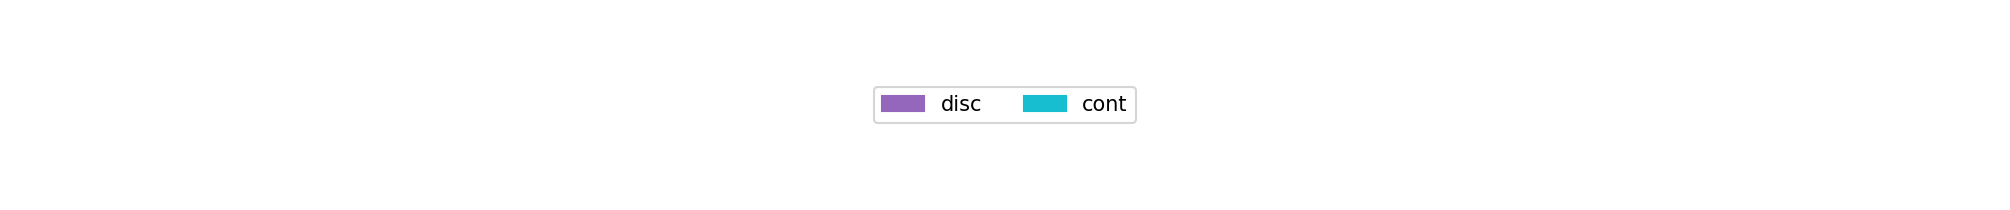

In [182]:
draw_BN(bn_geo, geo_types, 'geo_net')

In [183]:
params = parameter_learning(geo_only_discrete, geo_new_types, bn_geo)

In [184]:
save_structure(bn_geo, 'geo_net')
skel = read_structure('geo_net')
save_params(params, 'geo_net_param')
params = read_params('geo_net_param')
geo_bn = HyBayesianNetwork(skel, params)

In [185]:
acc, rmse, real, pred = calculate_acc(geo_bn, test_discrete, columns)

22
22
22
22
22
22
22
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, 

In [186]:
acc

{'Tectonic regime': 0.53,
 'Period': 0.24,
 'Lithology': 0.62,
 'Structural setting': 0.29,
 'Hydrocarbon type': 0.58,
 'Gross': 0.0,
 'Netpay': 0.0,
 'Porosity': 0.0,
 'Permeability': 0.0,
 'Depth': 0.0}

In [187]:
for key in colums_for_code:
    df_result_accuracy = df_result_accuracy.append({'Parameter': key, 'Strategy': 'HC', 'Alg':'M+D','accuracy':acc[key]}, ignore_index=True)

In [188]:
invers_real = inverse_discretization(pd.DataFrame(np.transpose(real[5:10]), columns=['Gross', 'Netpay', 'Porosity', 'Permeability', 'Depth']), ['Gross', 'Netpay', 'Porosity', 'Permeability', 'Depth'], discrete_coder)

In [189]:
invers_pred = inverse_discretization(pd.DataFrame(np.transpose(pred[5:10]), columns=['Gross', 'Netpay', 'Porosity', 'Permeability', 'Depth']), ['Gross', 'Netpay', 'Porosity', 'Permeability', 'Depth'], discrete_coder)

In [190]:
mean_squared_error(invers_real['Gross'], invers_pred['Gross'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'Gross', 'Strategy': 'HC', 'Alg':'M+D','rmse':mean_squared_error(invers_real['Gross'], invers_pred['Gross'], squared=False)}, ignore_index=True)

In [191]:
mean_squared_error(invers_real['Netpay'], invers_pred['Netpay'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'Netpay', 'Strategy': 'HC', 'Alg':'M+D','rmse':mean_squared_error(invers_real['Netpay'], invers_pred['Netpay'], squared=False)}, ignore_index=True)

In [192]:
mean_squared_error(invers_real['Porosity'], invers_pred['Porosity'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'Porosity', 'Strategy': 'HC', 'Alg':'M+D','rmse':mean_squared_error(invers_real['Porosity'], invers_pred['Porosity'], squared=False)}, ignore_index=True)

In [193]:
mean_squared_error(invers_real['Permeability'], invers_pred['Permeability'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'Permeability', 'Strategy': 'HC', 'Alg':'M+D','rmse':mean_squared_error(invers_real['Permeability'], invers_pred['Permeability'], squared=False)}, ignore_index=True)

In [194]:
mean_squared_error(invers_real['Depth'], invers_pred['Depth'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'Depth', 'Strategy': 'HC', 'Alg':'M+D','rmse':mean_squared_error(invers_real['Depth'], invers_pred['Depth'], squared=False)}, ignore_index=True)

# EVO

# Дискретная стурктура + смешанные параметры

In [195]:
bn_geo = structure_learning(geo_discrete, 'evo', 'MI', geo_types)

Cannot add to history: 'str' object has no attribute 'operation_type'
Best metric is 13.043500000000002
Generation num: 0
max_depth: 3, no improvements: 0
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.0 min
Best metric is 12.7807
Generation num: 1
max_depth: 3, no improvements: 0
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.1 min
Best metric is 12.575299999999999
Generation num: 2
max_depth: 3, no improvements: 0
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.1 min
Best metric is 12.575299999999999
Generation num: 3
max_depth: 3, no improvements: 1
Number of mutation attempts exceeded. Please check composer requirements for correctness.
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.1 min
Best metric is 9.6634
Generation num: 4
max_depth: 3, no improvements: 0
Cannot add to history: 'str' object has no attribute 'operation_type'
spent ti

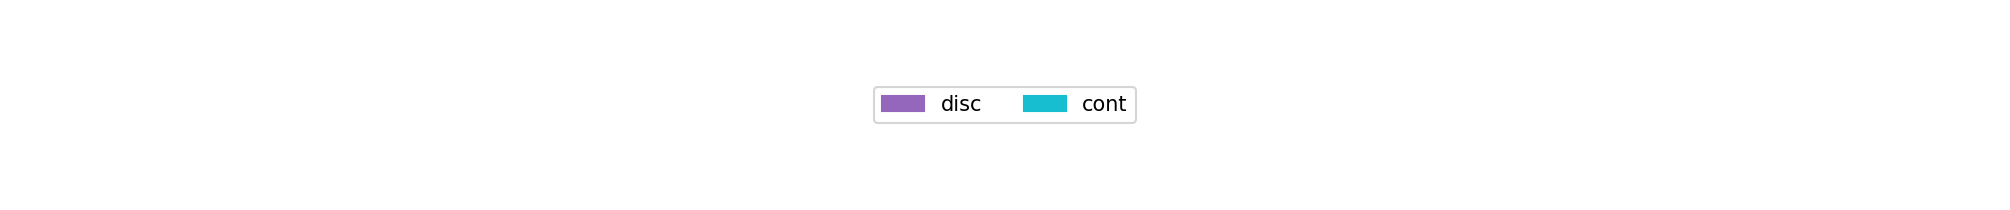

In [196]:
draw_BN(bn_geo, geo_types, 'geo_net')

In [197]:
params = parameter_learning(geo_train, geo_types, bn_geo)

In [198]:
save_structure(bn_geo, 'geo_net')
skel = read_structure('geo_net')
save_params(params, 'geo_net_param')
params = read_params('geo_net_param')
geo_bn = HyBayesianNetwork(skel, params)

In [199]:
acc, rmse, real_data, pred_data = calculate_acc(geo_bn, geo_test, columns)

22


In [200]:
acc

{'Tectonic regime': 0.53,
 'Period': 0.22,
 'Lithology': 0.51,
 'Structural setting': 0.36,
 'Hydrocarbon type': 0.67}

In [201]:
rmse

{'Gross': 456.29,
 'Netpay': 72.56,
 'Porosity': 6.12,
 'Permeability': 918.55,
 'Depth': 1263.7}

In [202]:
for key in acc.keys():
    df_result_accuracy = df_result_accuracy.append({'Parameter': key, 'Strategy': 'evo', 'Alg':'D+M','accuracy':acc[key]}, ignore_index=True)
for key in rmse.keys():
    df_result_rmse = df_result_rmse.append({'Parameter': key, 'Strategy': 'evo', 'Alg':'D+M','rmse':rmse[key]}, ignore_index=True)

In [203]:
sample_d_m_evo = pd.DataFrame(geo_bn.randomsample(700))
sample_d_m_evo_gross = sample_d_m_evo.loc[sample_d_m_evo['Gross'] > 0]
sample_d_m_evo_netpay = sample_d_m_evo.loc[sample_d_m_evo['Netpay'] > 0]
sample_d_m_evo_porosity = sample_d_m_evo.loc[sample_d_m_evo['Porosity'] > 0]
sample_d_m_evo_permeability = sample_d_m_evo.loc[sample_d_m_evo['Permeability'] > 0]
sample_d_m_evo_depth = sample_d_m_evo.loc[sample_d_m_evo['Depth'] > 0]

# Смешанная структура + смешанные параметры

In [204]:
bn_geo = structure_learning(geo_coded, 'evo', 'MI', geo_types)

Cannot add to history: 'str' object has no attribute 'operation_type'
Best metric is 26.6542707789494
Generation num: 0
max_depth: 3, no improvements: 0
Number of crossover attempts exceeded. Please check composer requirements for correctness.
Number of crossover attempts exceeded. Please check composer requirements for correctness.
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.2 min
Best metric is 26.28636647942097
Generation num: 1
max_depth: 3, no improvements: 0
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.2 min
Best metric is 22.420984352862078
Generation num: 2
max_depth: 3, no improvements: 0
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.3 min
Best metric is 22.420984352862078
Generation num: 3
max_depth: 3, no improvements: 1
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.4 min
Best metric is 22.20689057001438
Generation num: 4


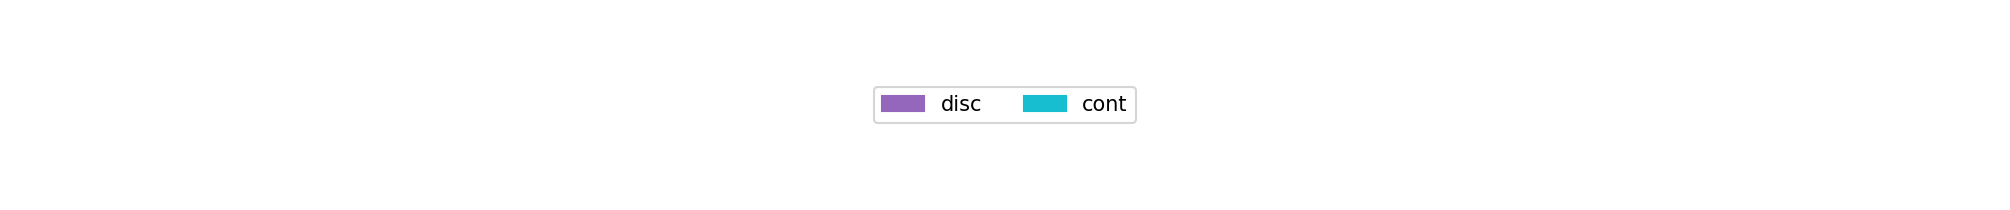

In [205]:
draw_BN(bn_geo, geo_types, 'geo_net')

In [206]:
params = parameter_learning(geo_train, geo_types, bn_geo)

In [207]:
save_structure(bn_geo, 'geo_net')
skel = read_structure('geo_net')
save_params(params, 'geo_net_param')
params = read_params('geo_net_param')
geo_bn = HyBayesianNetwork(skel, params)

In [208]:
acc, rmse, real, pred = calculate_acc(geo_bn, geo_test, columns)

In [209]:
acc

{'Tectonic regime': 0.53,
 'Period': 0.22,
 'Lithology': 0.51,
 'Structural setting': 0.2,
 'Hydrocarbon type': 0.67}

In [210]:
rmse

{'Gross': 460.51,
 'Netpay': 57.85,
 'Porosity': 7.13,
 'Permeability': 564.51,
 'Depth': 996.54}

In [211]:
for key in acc.keys():
    df_result_accuracy = df_result_accuracy.append({'Parameter': key, 'Strategy': 'evo', 'Alg':'M+M','accuracy':acc[key]}, ignore_index=True)
for key in rmse.keys():
    df_result_rmse = df_result_rmse.append({'Parameter': key, 'Strategy': 'evo', 'Alg':'M+M','rmse':rmse[key]}, ignore_index=True)

In [212]:
sample_m_m_evo = pd.DataFrame(geo_bn.randomsample(700))
sample_m_m_evo_gross = sample_m_m_evo.loc[sample_m_m_evo['Gross'] > 0]
sample_m_m_evo_netpay = sample_m_m_evo.loc[sample_m_m_evo['Netpay'] > 0]
sample_m_m_evo_porosity = sample_m_m_evo.loc[sample_m_m_evo['Porosity'] > 0]
sample_m_m_evo_permeability = sample_m_m_evo.loc[sample_m_m_evo['Permeability'] > 0]
sample_m_m_evo_depth = sample_m_m_evo.loc[sample_m_m_evo['Depth'] > 0]

# Дискретная структура + дискретные параметры

In [213]:
geo_new_types = {'Tectonic regime': 'disc',
 'Period': 'disc',
 'Lithology': 'disc',
 'Structural setting': 'disc',
 'Hydrocarbon type': 'disc',
 'Gross': 'disc',
 'Netpay': 'disc',
 'Porosity': 'disc',
 'Permeability': 'disc',
 'Depth': 'disc'}

In [214]:
bn_geo = structure_learning(geo_discrete, 'evo', 'MI', geo_new_types)

Cannot add to history: 'str' object has no attribute 'operation_type'
Best metric is 13.0164
Generation num: 0
max_depth: 3, no improvements: 0
Number of crossover attempts exceeded. Please check composer requirements for correctness.
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.0 min
Best metric is 10.923100000000002
Generation num: 1
max_depth: 3, no improvements: 0
Number of crossover attempts exceeded. Please check composer requirements for correctness.
Number of crossover attempts exceeded. Please check composer requirements for correctness.
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.1 min
Best metric is 10.860699999999998
Generation num: 2
max_depth: 3, no improvements: 0
Number of crossover attempts exceeded. Please check composer requirements for correctness.
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.1 min
Best metric is 10.7683
Generation num: 3
max_depth: 

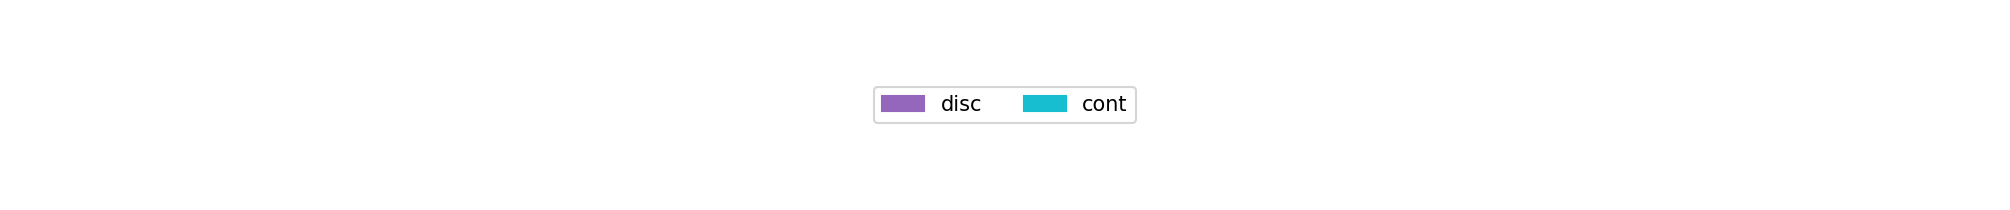

In [215]:
draw_BN(bn_geo, geo_types, 'geo_net')

In [216]:
params = parameter_learning(geo_only_discrete, geo_new_types, bn_geo)

In [217]:
save_structure(bn_geo, 'geo_net')
skel = read_structure('geo_net')
save_params(params, 'geo_net_param')
params = read_params('geo_net_param')
geo_bn = HyBayesianNetwork(skel, params)

In [218]:
acc, rmse, real, pred = calculate_acc(geo_bn, test_discrete, columns)

C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future wil

In [219]:
acc

{'Tectonic regime': 0.53,
 'Period': 0.38,
 'Lithology': 0.51,
 'Structural setting': 0.2,
 'Hydrocarbon type': 0.67,
 'Gross': 0.0,
 'Netpay': 0.0,
 'Porosity': 0.0,
 'Permeability': 0.0,
 'Depth': 0.0}

In [220]:
for key in colums_for_code:
    df_result_accuracy = df_result_accuracy.append({'Parameter': key, 'Strategy': 'evo', 'Alg':'D+D','accuracy':acc[key]}, ignore_index=True)

In [221]:
invers_real = inverse_discretization(pd.DataFrame(np.transpose(real[5:10]), columns=['Gross', 'Netpay', 'Porosity', 'Permeability', 'Depth']), ['Gross', 'Netpay', 'Porosity', 'Permeability', 'Depth'], discrete_coder)

In [222]:
invers_pred = inverse_discretization(pd.DataFrame(np.transpose(pred[5:10]), columns=['Gross', 'Netpay', 'Porosity', 'Permeability', 'Depth']), ['Gross', 'Netpay', 'Porosity', 'Permeability', 'Depth'], discrete_coder)

In [223]:
mean_squared_error(invers_real['Gross'], invers_pred['Gross'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'Gross', 'Strategy': 'evo', 'Alg':'D+D','rmse':mean_squared_error(invers_real['Gross'], invers_pred['Gross'], squared=False)}, ignore_index=True)

In [224]:
mean_squared_error(invers_real['Netpay'], invers_pred['Netpay'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'Netpay', 'Strategy': 'evo', 'Alg':'D+D','rmse':mean_squared_error(invers_real['Netpay'], invers_pred['Netpay'], squared=False)}, ignore_index=True)

In [225]:
mean_squared_error(invers_real['Porosity'], invers_pred['Porosity'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'Porosity', 'Strategy': 'evo', 'Alg':'D+D','rmse':mean_squared_error(invers_real['Porosity'], invers_pred['Porosity'], squared=False)}, ignore_index=True)


In [226]:
mean_squared_error(invers_real['Permeability'], invers_pred['Permeability'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'Permeability', 'Strategy': 'evo', 'Alg':'D+D','rmse':mean_squared_error(invers_real['Permeability'], invers_pred['Permeability'], squared=False)}, ignore_index=True)

In [227]:
mean_squared_error(invers_real['Depth'], invers_pred['Depth'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'Depth', 'Strategy': 'evo', 'Alg':'D+D','rmse':mean_squared_error(invers_real['Depth'], invers_pred['Depth'], squared=False)}, ignore_index=True)

In [228]:
sample_d_d_evo = pd.DataFrame(geo_bn.randomsample(500))
sample_d_d_evo = inverse_discretization(sample_d_d_evo, columns_for_disc, discrete_coder)

# Смешанная структура + дискретные параметры

In [229]:
bn_geo = structure_learning(geo_coded, 'evo', 'MI', geo_new_types)

Cannot add to history: 'str' object has no attribute 'operation_type'
Best metric is 31.97466948421311
Generation num: 0
max_depth: 3, no improvements: 0
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.2 min
Best metric is 30.700291289811332
Generation num: 1
max_depth: 3, no improvements: 0
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.3 min
Best metric is 27.83982836024703
Generation num: 2
max_depth: 3, no improvements: 0
Number of crossover attempts exceeded. Please check composer requirements for correctness.
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.4 min
Best metric is 27.69950838901765
Generation num: 3
max_depth: 3, no improvements: 0
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.5 min
Best metric is 27.39625674411706
Generation num: 4
max_depth: 3, no improvements: 0
Cannot add to history: 'str' object has no attribute 'oper

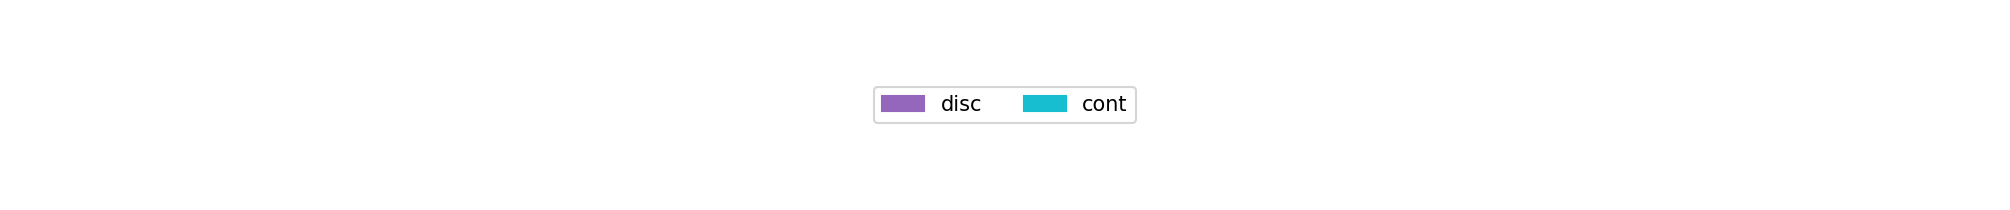

In [230]:
draw_BN(bn_geo, geo_types, 'geo_net')

In [231]:
params = parameter_learning(geo_only_discrete, geo_new_types, bn_geo)

In [232]:
save_structure(bn_geo, 'geo_net')
skel = read_structure('geo_net')
save_params(params, 'geo_net_param')
params = read_params('geo_net_param')
geo_bn = HyBayesianNetwork(skel, params)

In [233]:
acc, rmse, real, pred = calculate_acc(geo_bn, test_discrete, columns)

C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future wil

In [234]:
acc

{'Tectonic regime': 0.53,
 'Period': 0.22,
 'Lithology': 0.51,
 'Structural setting': 0.2,
 'Hydrocarbon type': 0.67,
 'Gross': 0.0,
 'Netpay': 0.0,
 'Porosity': 0.0,
 'Permeability': 0.0,
 'Depth': 0.0}

In [235]:
for key in colums_for_code:
    df_result_accuracy = df_result_accuracy.append({'Parameter': key, 'Strategy': 'evo', 'Alg':'M+D','accuracy':acc[key]}, ignore_index=True)

In [236]:
invers_real = inverse_discretization(pd.DataFrame(np.transpose(real[5:10]), columns=['Gross', 'Netpay', 'Porosity', 'Permeability', 'Depth']), ['Gross', 'Netpay', 'Porosity', 'Permeability', 'Depth'], discrete_coder)


In [237]:
invers_pred = inverse_discretization(pd.DataFrame(np.transpose(pred[5:10]), columns=['Gross', 'Netpay', 'Porosity', 'Permeability', 'Depth']), ['Gross', 'Netpay', 'Porosity', 'Permeability', 'Depth'], discrete_coder)

In [238]:
mean_squared_error(invers_real['Gross'], invers_pred['Gross'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'Gross', 'Strategy': 'evo', 'Alg':'M+D','rmse':mean_squared_error(invers_real['Gross'], invers_pred['Gross'], squared=False)}, ignore_index=True)

In [239]:
mean_squared_error(invers_real['Netpay'], invers_pred['Netpay'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'Netpay', 'Strategy': 'evo', 'Alg':'M+D','rmse':mean_squared_error(invers_real['Netpay'], invers_pred['Netpay'], squared=False)}, ignore_index=True)

In [240]:
mean_squared_error(invers_real['Porosity'], invers_pred['Porosity'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'Porosity', 'Strategy': 'evo', 'Alg':'M+D','rmse':mean_squared_error(invers_real['Porosity'], invers_pred['Porosity'], squared=False)}, ignore_index=True)

In [241]:
mean_squared_error(invers_real['Permeability'], invers_pred['Permeability'], squared=False)
df_result_rmse = df_result_rmse = df_result_rmse.append({'Parameter': 'Permeability', 'Strategy': 'evo', 'Alg':'M+D','rmse':mean_squared_error(invers_real['Permeability'], invers_pred['Permeability'], squared=False)}, ignore_index=True)

In [242]:
mean_squared_error(invers_real['Depth'], invers_pred['Depth'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'Depth', 'Strategy': 'evo', 'Alg':'M+D','rmse':mean_squared_error(invers_real['Depth'], invers_pred['Depth'], squared=False)}, ignore_index=True)

In [243]:
df_result_accuracy.to_csv('geo_results_disc.csv', index=False)
df_result_rmse.to_csv('geo_results_cont.csv', index=False)

C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either 

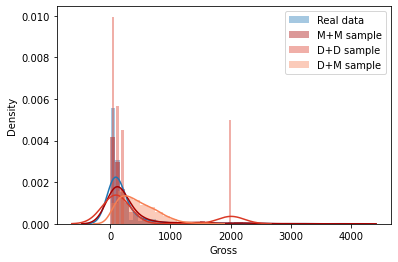

In [244]:
sns.distplot(geo['Gross'], label = 'Real data')
sns.distplot(sample_m_m_hc_gross['Gross'], label = 'M+M sample', color=sns.color_palette("OrRd", 10)[9])
sns.distplot(sample_d_d_hc['Gross'], label='D+D sample', color=sns.color_palette("OrRd", 10)[7])
sns.distplot(sample_d_m_hc_gross['Gross'], label='D+M sample', color=sns.color_palette("OrRd", 10)[5])
plt.legend()

In [260]:
stats.anderson(sample_m_m_hc_gross['Gross'].values, 'extreme1')

AndersonResult(statistic=73.82553286538416, critical_values=array([0.469, 0.63 , 0.749, 0.868, 1.027]), significance_level=array([25. , 10. ,  5. ,  2.5,  1. ]))

C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either 

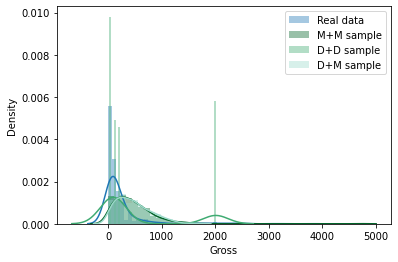

In [245]:
sns.distplot(geo['Gross'], label = 'Real data')
sns.distplot(sample_m_m_evo_gross['Gross'], label = 'M+M sample', color=sns.color_palette("BuGn", 10)[9])
sns.distplot(sample_d_d_evo['Gross'], label='D+D sample', color=sns.color_palette("BuGn", 10)[6])
sns.distplot(sample_d_m_evo_gross['Gross'], label='D+M sample', color=sns.color_palette("BuGn", 10)[3])
plt.legend()

C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either 

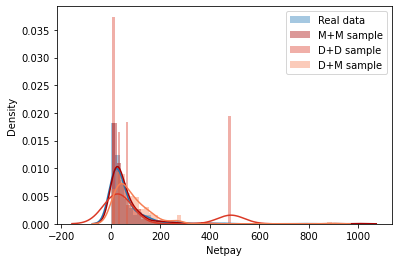

In [246]:
sns.distplot(geo['Netpay'], label = 'Real data')
sns.distplot(sample_m_m_hc_netpay['Netpay'], label = 'M+M sample', color=sns.color_palette("OrRd", 10)[9])
sns.distplot(sample_d_d_hc['Netpay'], label='D+D sample', color=sns.color_palette("OrRd", 10)[7])
sns.distplot(sample_d_m_hc_netpay['Netpay'], label='D+M sample', color=sns.color_palette("OrRd", 10)[5])
plt.legend()

C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either 

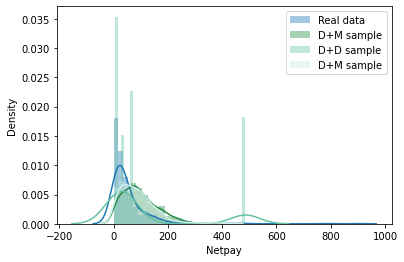

In [247]:
sns.distplot(geo['Netpay'], label = 'Real data')
sns.distplot(sample_d_m_evo_netpay['Netpay'], label = 'D+M sample', color=sns.color_palette("BuGn", 3)[2])
sns.distplot(sample_d_d_evo['Netpay'], label='D+D sample', color=sns.color_palette("BuGn", 3)[1])
sns.distplot(sample_m_m_evo_netpay['Netpay'], label='D+M sample', color=sns.color_palette("BuGn",3)[0])
plt.legend()

C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either 

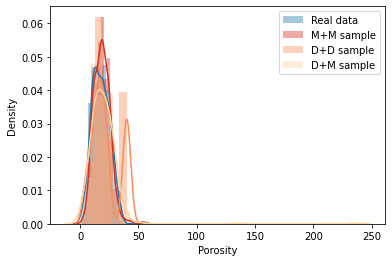

In [248]:
sns.distplot(geo['Porosity'], label = 'Real data')
sns.distplot(sample_m_m_hc_porosity['Porosity'], label = 'M+M sample', color=sns.color_palette("OrRd", 3)[2])
sns.distplot(sample_d_d_hc['Porosity'], label='D+D sample', color=sns.color_palette("OrRd", 3)[1])
sns.distplot(sample_d_m_hc_porosity['Porosity'], label='D+M sample', color=sns.color_palette("OrRd", 3)[0])
plt.legend()

C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either 

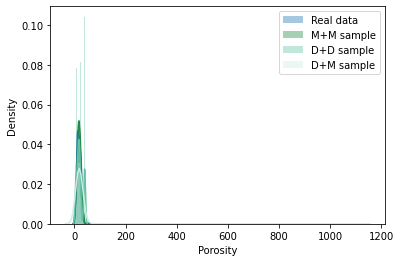

In [249]:
sns.distplot(geo['Porosity'], label = 'Real data')
sns.distplot(sample_m_m_evo_porosity['Porosity'], label = 'M+M sample', color=sns.color_palette("BuGn", 3)[2])
sns.distplot(sample_d_d_evo['Porosity'], label='D+D sample', color=sns.color_palette("BuGn", 3)[1])
sns.distplot(sample_d_m_evo_porosity['Porosity'], label='D+M sample', color=sns.color_palette("BuGn", 3)[0])
plt.legend()

C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either 

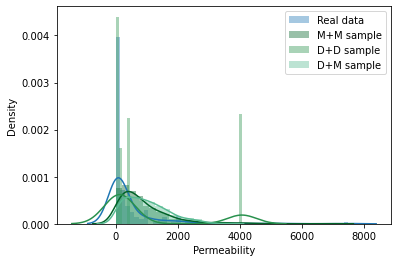

In [250]:
sns.distplot(geo['Permeability'], label = 'Real data')
sns.distplot(sample_m_m_evo_permeability['Permeability'], label = 'M+M sample', color=sns.color_palette("BuGn", 10)[9])
sns.distplot(sample_d_d_evo['Permeability'], label='D+D sample', color=sns.color_palette("BuGn", 10)[7])
sns.distplot(sample_d_m_evo_permeability['Permeability'], label='D+M sample', color=sns.color_palette("BuGn", 10)[5])
plt.legend()

C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either 

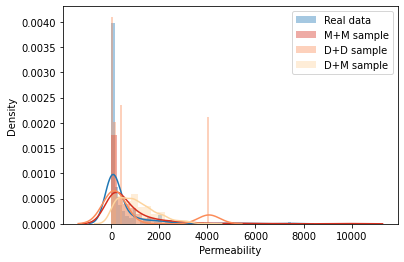

In [251]:
sns.distplot(geo['Permeability'], label = 'Real data')
sns.distplot(sample_m_m_hc_permeability['Permeability'], label = 'M+M sample', color=sns.color_palette("OrRd", 3)[2])
sns.distplot(sample_d_d_hc['Permeability'], label='D+D sample', color=sns.color_palette("OrRd", 3)[1])
sns.distplot(sample_d_m_hc_permeability['Permeability'], label='D+M sample', color=sns.color_palette("OrRd", 3)[0])
plt.legend()

C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either 

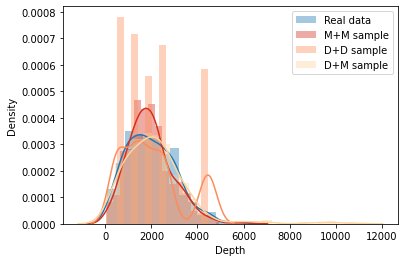

In [252]:
sns.distplot(geo['Depth'], label = 'Real data')
sns.distplot(sample_m_m_hc_depth['Depth'], label = 'M+M sample', color=sns.color_palette("OrRd", 3)[2])
sns.distplot(sample_d_d_hc['Depth'], label='D+D sample', color=sns.color_palette("OrRd", 3)[1])
sns.distplot(sample_d_m_hc_depth['Depth'], label='D+M sample', color=sns.color_palette("OrRd", 3)[0])
plt.legend()

C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either 

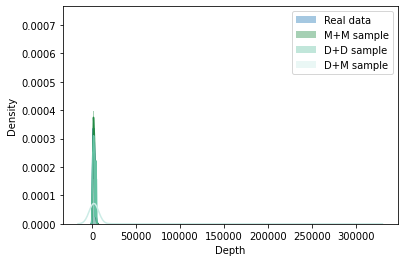

In [253]:
sns.distplot(geo['Depth'], label = 'Real data')
sns.distplot(sample_m_m_evo_depth['Depth'], label = 'M+M sample', color=sns.color_palette("BuGn", 3)[2])
sns.distplot(sample_d_d_evo['Depth'], label='D+D sample', color=sns.color_palette("BuGn", 3)[1])
sns.distplot(sample_d_m_evo_depth['Depth'], label='D+M sample', color=sns.color_palette("BuGn", 3)[0])
plt.legend()